In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

from planet_ruler.observation import LimbObservation, plot_diff_evol_posteriors, package_results, unpack_diff_evol_posteriors
# from planet_ruler.fit import unpack_parameters, plot_diff_evol_posteriors, package_results, unpack_diff_evol_posteriors

# Load an Image

In [2]:
Obs = LimbObservation(image_filepath='../demo/nh-apluto-wide-9-17-15-final_0.png',
                      fit_config='../config/basic_resection.yaml')

Let's start out with this image from NASA's New Horizons mission. A couple things to note:

- You can clearly see the 'limb' of Pluto here -- the edge where the dwarf planet meets space.
- We are obviously quite high up (around 1,200 km), which makes the curvature really apparent.

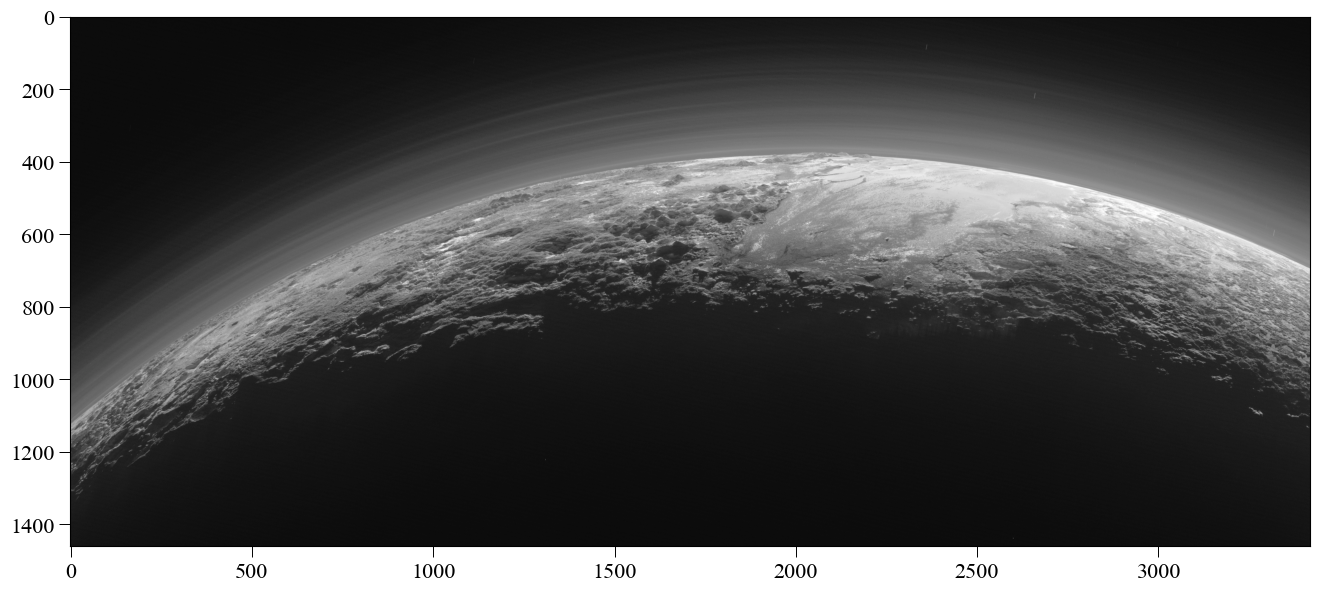

In [3]:
Obs.plot()

# Detect Limb

Next we want to define where the limb is so we can start figuring out the radius. There are many ways to go about this. For example, we could look for regions of high contrast, train some object detection ML, or simply draw by hand. Being a physics nerd I will do something a little different and fun -- we will simulate dropping a string down from the top of the image and let it 'settle' on the limb.

To make that happen we first turn the image into a topographical map by treating pixel brightness as elevation. That might look something like so:

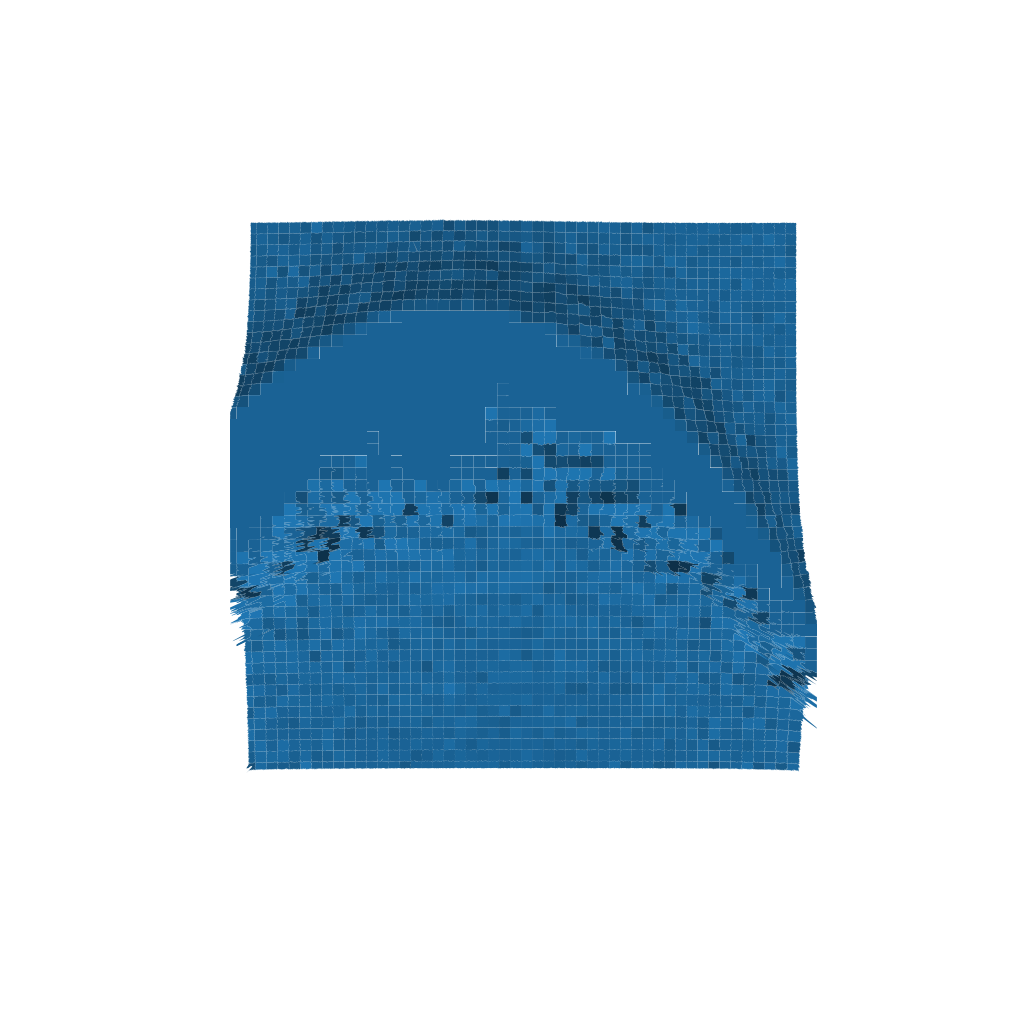

In [4]:
import matplotlib.pyplot as plt
from matplotlib.colors import LightSource

fig, ax = plt.subplots(subplot_kw=dict(projection='3d'), figsize=(10, 10))

# summing each pixel across colors to get intensity
z = Obs.image.sum(axis=-1)
z = np.clip(z, None, 500)
nrows, ncols = z.shape
x = np.arange(ncols)
y = np.arange(nrows) 

x, y = np.meshgrid(x, y)

ls = LightSource(altdeg=30, azdeg=-15)
ax.plot_surface(x, y, z, lightsource=ls)
ax.view_init(elev=90, azim=0, roll=-90)

plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
                    hspace = 0, wspace = 0)

plt.axis('off')
plt.show()

If we tilt this landscape back somewhat and drop a string (subject to gravity and tension) onto it, it will settle where the hill starts to rise -- exactly the limb we are trying to detect.

Running the next line will perform the simulation. It takes a couple minutes but the results are pretty robust, as most physical systems are.

In [5]:
Obs.detect_limb()

computing gradient force map...
dropping horizon string...


  0%|          | 0/1000000 [00:00<?, ?it/s]

Let's take a look at the position of the string over time. It becomes less transparent as time evolves and it settles onto the limb.

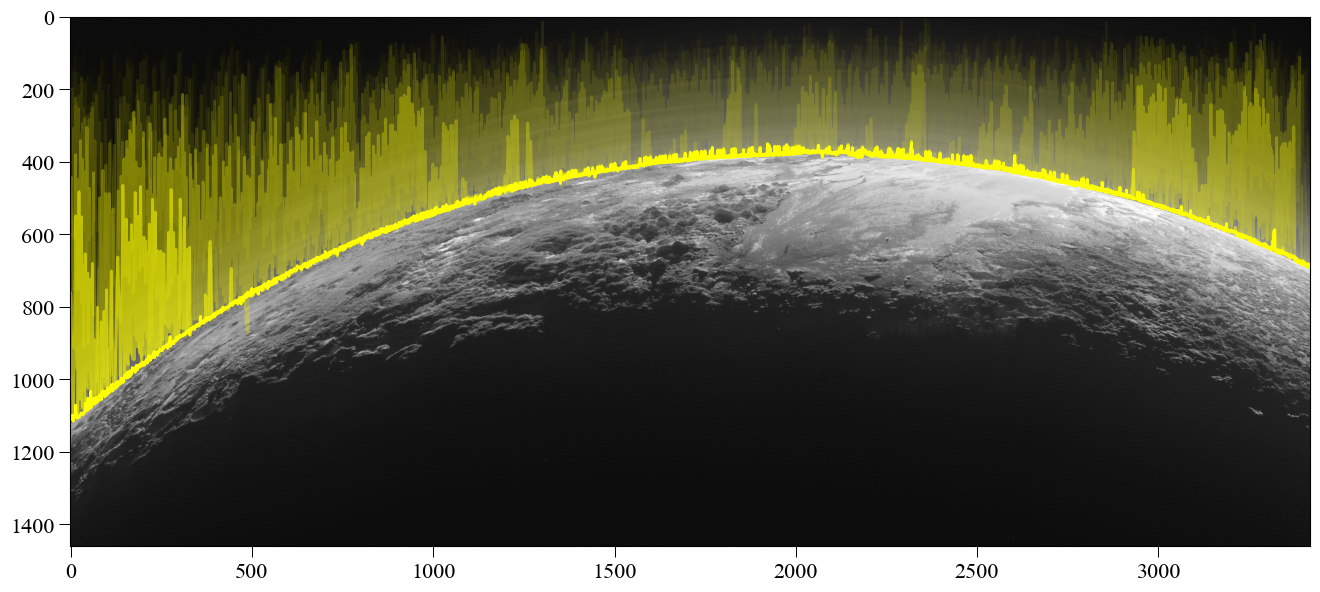

In [6]:
string_positions = Obs._string_drop.string_positions
n_pos = len(string_positions)

plt.imshow(Obs.image)
steps = np.logspace(1, np.log10(n_pos - 1), num=20).astype(int)
for step in steps:
    pos = string_positions[step]
    plt.plot(np.arange(len(pos)), pos, c='yellow', alpha=(step)/(n_pos))
plt.show()

We can now smooth things out and take a look at the fitted limb location.

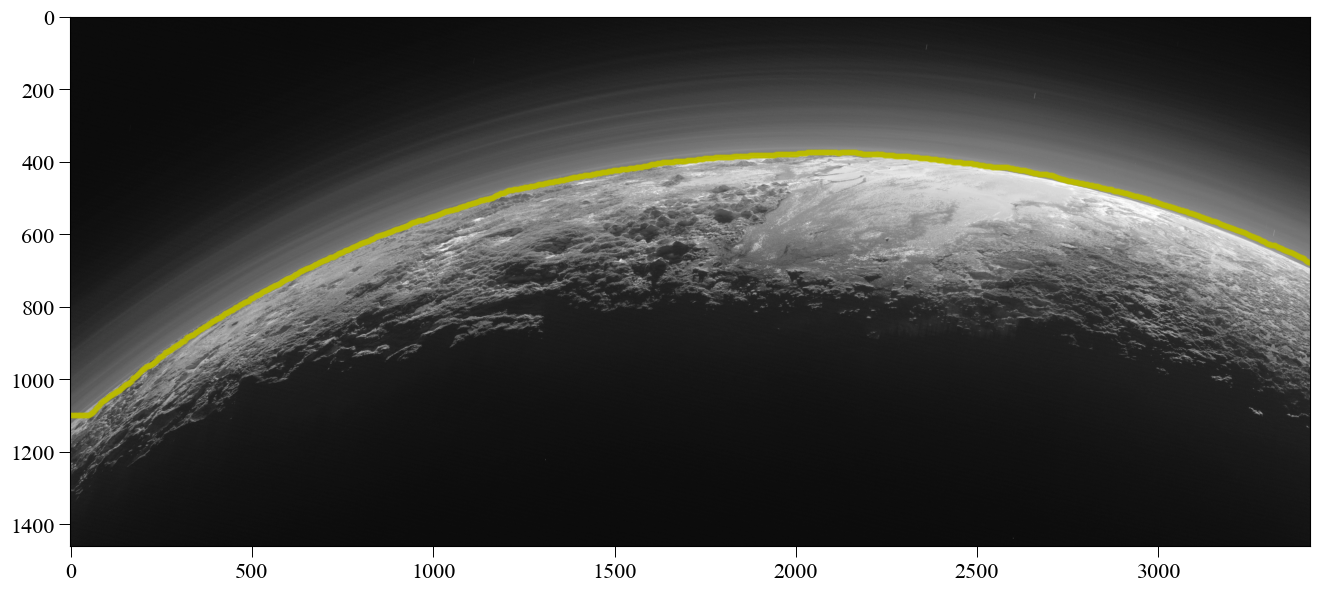

In [7]:
Obs.smooth_limb(method='rolling-median', window_length=50)
Obs.plot()

Let's add a save point in case we don't want to do all that again.

In [8]:
limb_save = 'pluto_limb.npy'
Obs.save_limb(limb_save)

# Fit Planet Radius

Now for the hard part. We need to deduce the radius of the object below us by leveraging what we know and fitting what we do not.

So -- what do we know?

Let's start with a list of the free parameters in the fit. These are:
- **[r]** Radius of the planet (m)
- **[h]** Height of the camera above the surface (m)
- **[f]** Focal length of the camera (m)
- **[pxy]** The scale of pixel width/height on the projection plane (m)
- **[px]** The relative scale of x pixels (vs. y)
- **[x0]** The x-axis principle point (center of the image in pixel space -- really should be close to 0)
- **[y0]** Same as x0 but for the y-axis
- **[theta_x]** Rotation around the x (horizontal) axis, AKA pitch. (radians)
- **[theta_y]** Rotation around the y (toward the limb) axis, AKA roll. (radians)
- **[theta_z]** Rotation around the z (vertical) axis, AKA yaw. (radians)
- **[origin_x]** Horizontal offset from the object in question to the camera (m)
- **[origin_y]** Distance from the object in question to the camera (m)
- **[origin_z]** Height difference from the object in question to the camera (m)

To help the fit we can give initial guesses and boundaries to each of these features. This is a tough optimization with a lot of parameter space, degeneracies, and weird inflection points, so the more help we can give the more likely we are to get somewhere meaningful. Let's step through the parameters.

- **[r]** Radius of the planet (m)
  
> Obviously we are trying to find out **r** so we might not have much to go on here, but that doesn't mean we can't put in some reasonable bounds. We know for example that we are looking at a rocky dwarf planet that is quite spherical which is a clue to the minimum radius. I leave it to the user to do that napkin math -- today let's just put in a guess for the radius at 750 km -- in the ballpark of the truth (1188 km) but not so close to give away the answer. We set the bounds loosely to 600-1600 km.

- **[h]** Height of the camera above the surface (m)

> Here we can make a guess using the known parameters of NASA's New Horizons mission. The point of closest approach to Pluto was 12,500 km, so we'll start there, again plus or minus a few thousand km as boundaries.

- **[f]** Focal length of the camera (m)

> From the stated mission parameters, the [RALPH](https://www.boulder.swri.edu/pkb/ssr/ssr-ralph.pdf) camera has a 75mm focal length. Since we're pretty sure about this one, let's give it a very small (0.1mm) tolerance.

- **[pxy]** The scale of pixel width/height on the projection plane (m)

> This one is a bit of a mystery to me what it should be. After running the optimization a few times I was able to give it a rough set of limits to where it seems to settle -- currently between 1 and 300.

- **[px]** The relative scale of x pixels (vs. y)

> This might be in the description of the CCD for the RALPH camera somewhere but I just set it widely to between 0.1 and 2.0.

- **[x0]** The x-axis principle point (center of the image in pixel space -- really should be close to 0)
- **[y0]** Same as x0 but for the y-axis

> I believe these are basically tolerance parameters for the camera as it's hard to imagine someone designing a CCD plane on purpose with an off-center focal point. Set to a very small tolerance (-5e-4 to 5e-4) as they actually have a tremendous effect on the image if they are far out of alignment.

- **[theta_x]** Rotation around the x (horizontal) axis, AKA pitch. (radians)
- **[theta_y]** Rotation around the y (toward the limb) axis, AKA roll. (radians)
- **[theta_z]** Rotation around the z (vertical) axis, AKA yaw. (radians)

> These describe where the camera is pointing. 'Straight ahead' depends a bit on how you define your coordinates, but we set these in that range with ranges of around 20 degrees either way.

- **[origin_x]** Horizontal offset from the object in question to the camera (m)
- **[origin_y]** Distance from the object in question to the camera (m)
- **[origin_z]** Height difference from the object in question to the camera (m)

> These tell us where the camera is in space relative to the target. For a far-off limb, you can set origin_y to something like h. Otherwise you can use geometry.horizon_distance to calculate it based on your h and estimate of r (that's actually what was done here). The other two origins are a bit of a toss-up. I set the limits to something like 1000 km either direction and then refined a little after seeing some fit posteriors.

You can see the current initial parameter set [here](https://github.com/bogsdarking/planet_ruler/blob/c8c0a39cae7712363491bc60c861d1a2e410b745/config/pluto-new-horizons.yaml).

Let's try that fit!

In [9]:
limb_save = 'pluto_limb.npy'
Obs.load_limb(limb_save)

In [ ]:
# Note we point to the parameter config that we want.
Obs.load_fit_config('../config/pluto-new-horizons.yaml')
# Set n_jobs to the number of processors you feel comfortable abusing.
Obs.fit_limb(max_iter=10000, n_jobs=4, seed=0)

## Check Fit

### By Eye

Not bad, right? It's quite easy to end up with a fit that doesn't converge well and appears to have nothing to do with the limb in question. If that happens, don't despair! If the limb detection went okay, it usually it means some tweaking of the parameter ranges or optimizer properties is in order.

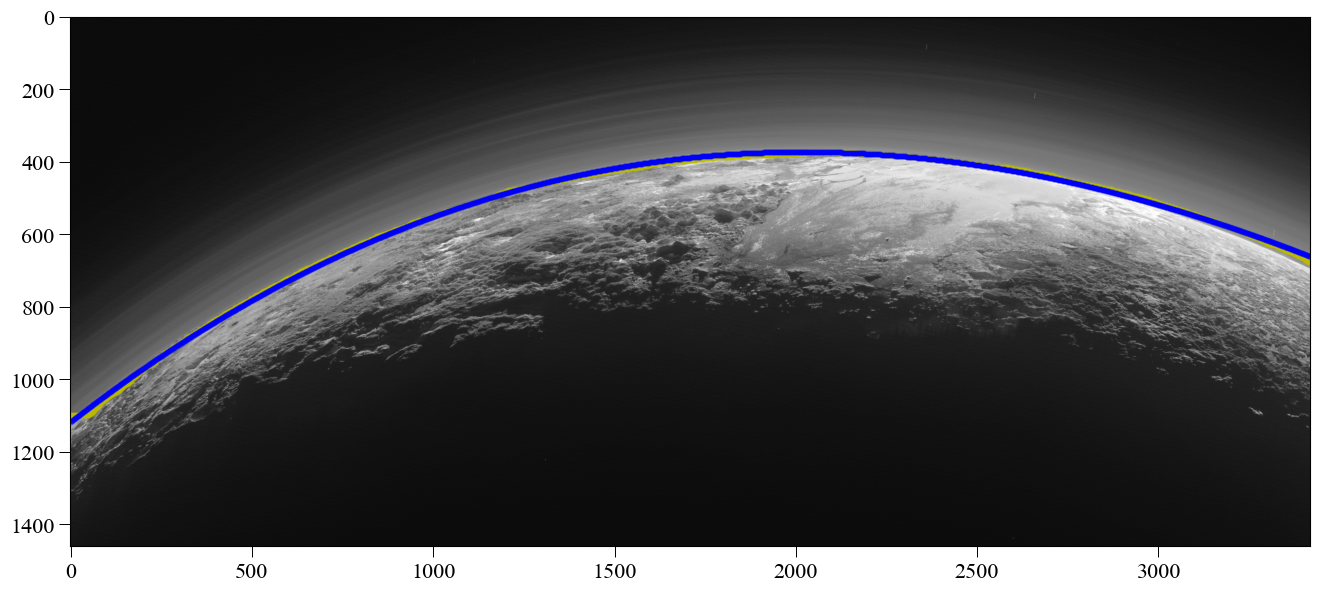

In [11]:
Obs.plot()

### Posteriors

To understand this section you need to know a bit about what minimizer we used to solve the problem. This is using something called [differential evolution](https://en.wikipedia.org/wiki/Differential_evolution). It's a (terribly named) way of minimizing a loss function that is non-differentiable. Basically it simulates the 'evolution' of a population composed of parameter value sets. So [r=1, h=2, etc.] could be one unit of the population. These units are mutated and combined over many generations where only the best-fitting survive. When we end the simulation we have an optimal parameter set and a population that is hopefully still competitive. We can think of that population as something like a 'posterior', or measure of uncertainty in each parameter's observed value. Another totally valid method of optimization would have been a Bayesian MCMC and it would also give us posterior distributions that we could check out.

Below we plot all these populations/posteriors and see if they look good. What is good? Ideally they should form a concave U-shape around the best value and not be too much up against either of the limits we imposed in the fit. If the latter is taking place, we might not be reaching the true minimum and it's hard to take the results too seriously. In that case, try the fit again but move the constraints out a little to give the fit some breathing room. I say a little bit because you don't want to make the constraints too wide either -- there really is a sweet spot that doesn't explicitly block the best parameter values, but gives the minimizer enough to work with that it can arrive there in our lifetimes.

I already went through the trial and error to get the following posteriors to look right -- if implementing the code on a new image, take these an example of what to shoot for.

In [ ]:
plot_diff_evol_posteriors(Obs)

# The Answer!

At long last. After convincing ourselves that we can trust our results, let's take a look.

In [13]:
fitted_radius = Obs.best_parameters['r'] / 1000
fit_population = unpack_diff_evol_posteriors(Obs)
rough_uncertainty = fit_population['r'].std() / 1000
pct_error = (fitted_radius - 1188) / 1188 * 100

print(f"Our estimate of Pluto's radius is{fitted_radius: .1f} \u00B1{rough_uncertainty: .0f} kilometers.")
print(f"That puts us only {pct_error: .1f}% away from the true value of 1188 km!")

Our estimate of Pluto's radius is 1156.4 ± 8 kilometers.
That puts us only -2.7% away from the true value of 1188 km!


The value is quite close to the truth. I wouldn't plan a space trip around it but it isn't bad for a single image and rough idea of what camera was used!

See below where all the other parameters ended up relative to their initial values.

In [14]:
package_results(Obs)

,fit value,initial value
parameter,,
r,1.156353e+06,7.500000e+05
h,1.292728e+07,1.250000e+07
f,7.500645e-02,7.500000e-02
pxy,2.208257e+02,5.000000e+01
px,2.481227e-01,1.000000e+00
x0,-2.020731e-05,0.000000e+00
y0,9.425532e-05,0.000000e+00
theta_x,-1.548026e+00,1.000000e+00
theta_y,2.507472e-01,-5.000000e-01
